Prevendo a qualidade sensorial de um vinho (bom vs ruim) com base nas características físico-químicas e quais variáveis possuem maior influência na predição utilizando Árvores de Decisão

In [ ]:
%pip install --user scikit-learn imbalanced-learn pandas seaborn matplotlib pyarrow shap

In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve,
    auc, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [136]:
def gerar_tabela_metricas(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    report_train = classification_report(y_train, y_train_pred, output_dict=True)
    report_test = classification_report(y_test, y_test_pred, output_dict=True)
    linhas = ['Precisão', 'Recall', 'F1-Score', 'Suporte']
    index = pd.MultiIndex.from_product([['Teste', 'Treino'], linhas])
    tabela = pd.DataFrame(index=index, columns=['Vinhos Ruins', 'Vinhos Bons', 'Média', 'Média Ponderada'])
    def preencher(relatorio, tipo):
        tabela.loc[(tipo, 'Precisão')] = [
            relatorio['0']['precision'],
            relatorio['1']['precision'],
            relatorio['macro avg']['precision'],
            relatorio['weighted avg']['precision']
        ]
        tabela.loc[(tipo, 'Recall')] = [
            relatorio['0']['recall'],
            relatorio['1']['recall'],
            relatorio['macro avg']['recall'],
            relatorio['weighted avg']['recall']
        ]
        tabela.loc[(tipo, 'F1-Score')] = [
            relatorio['0']['f1-score'],
            relatorio['1']['f1-score'],
            relatorio['macro avg']['f1-score'],
            relatorio['weighted avg']['f1-score']
        ]
        tabela.loc[(tipo, 'Suporte')] = [
            relatorio['0']['support'],
            relatorio['1']['support'],
            np.nan,
            np.nan
        ]
    preencher(report_test, 'Teste')
    preencher(report_train, 'Treino')
    return tabela.round(3)

def style_confusion_texts(ax):
    for text in ax.texts:
        val = text.get_text()
        try:
            val_num = int(val)
            if val_num == 0:
                text.set_color("gray")
            elif val_num < 5:
                text.set_color("red")
            else:
                text.set_color("black")
        except:
            continue

def treinar_decision_tree(X_train, y_train):
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    return clf

def avaliar_metricas_basicas(modelo, X_train, y_train, X_test, y_test, nome_modelo):
    tabela = gerar_tabela_metricas(modelo, X_train, y_train, X_test, y_test)
    print(f"\n===== Tabela de Métricas ({nome_modelo}) =====")
    print(tabela)
    acc_train = accuracy_score(y_train, modelo.predict(X_train))
    acc_test = accuracy_score(y_test, modelo.predict(X_test))
    print(f"\nAcurácia Treino: {acc_train:.4f}")
    print(f"Acurácia Teste : {acc_test:.4f}")
    return acc_train, acc_test
 
def avaliar_cross_validation(modelo, X_train, y_train, acc_teste, nome_modelo):
    cv_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    print(f"\nCV Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
    diff = abs(cv_mean - acc_teste)
    limiar = 0.05
    if diff > limiar:
        print(f"Atenção: Diferença significativa entre CV e teste: {diff:.4f}")
    else:
        print("Modelo generaliza bem com base em CV vs Teste.")
    return cv_mean, diff

def plotar_comparacao_cv_teste(cv_mean, acc_test, diff, nome_modelo):
    df_plot = pd.DataFrame({
        "Categoria": ["CV Média", "Acurácia no Teste"],
        "Acurácia": [cv_mean, acc_test],
        "Modelo": [nome_modelo] * 2
    })
    sns.barplot(x="Categoria", y="Acurácia", hue="Modelo", data=df_plot, palette='Blues')
    plt.plot([0, 1], [cv_mean, acc_test], 'k--', label=f'Diferença: {diff:.4f}')
    plt.title(f"Comparação entre Acurácia CV e Teste ({nome_modelo})")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plotar_curva_precision_recall(modelo, X_test, y_test, nome_modelo):
    y_proba = modelo.predict_proba(X_test)[:, 1]
    precisao, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precisao)
    plt.plot(recall, precisao, label=f'{nome_modelo} (AUC = {pr_auc:.3f})')
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.title(f"Curva de Precisão-Recall ({nome_modelo})")
    plt.legend()
    plt.grid(True)
    plt.show()
 
def plotar_matrizes_confusao(modelo, X_train, y_train, X_test, y_test, nome_modelo):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_estimator(modelo, X_train, y_train, ax=axes[0], cmap='Blues')
    axes[0].set_title("Treino")
    ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, ax=axes[1], cmap='Blues')
    axes[1].set_title("Teste")
    style_confusion_texts(axes[0])
    style_confusion_texts(axes[1])
    plt.suptitle(f"Matrizes de Confusão ({nome_modelo})")
    plt.tight_layout()
    plt.show()

def visualizar_arvore(modelo, X_train, nome_modelo):
    plt.figure(figsize=(20, 10))
    plot_tree(modelo, feature_names=X_train.columns, class_names=['Ruim', 'Bom'], filled=True, max_depth=3)
    plt.title(f"Visualização parcial da Árvore de Decisão ({nome_modelo})")
    plt.show()

def plotar_importancia_features(modelo, X_train, nome_modelo):
    importances = modelo.feature_importances_
    df_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importances, palette='viridis', hue='Feature', legend=False)
    plt.title(f'Importância das Features - {nome_modelo}')
    plt.tight_layout()
    plt.show()
    print(df_importances)

In [137]:
# Carregando dados
df = pd.read_parquet('data/processed/wine-quality.parquet')
print("Colunas do dataset carregado:", df.columns.tolist())

Colunas do dataset carregado: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


Coluna 'type' codificada.

Distribuição das classes (good_quality):
good_quality
1    4113
0    2384
Name: count, dtype: int64


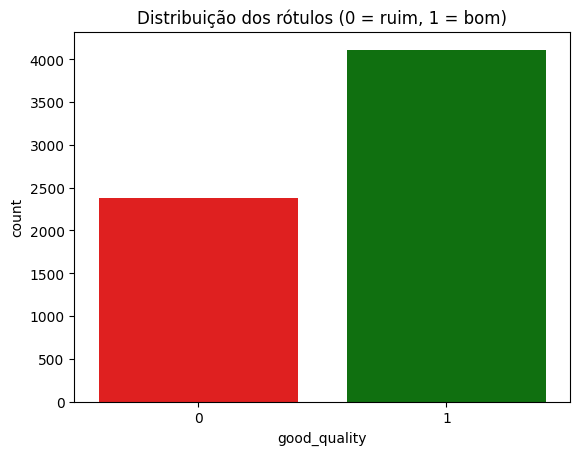

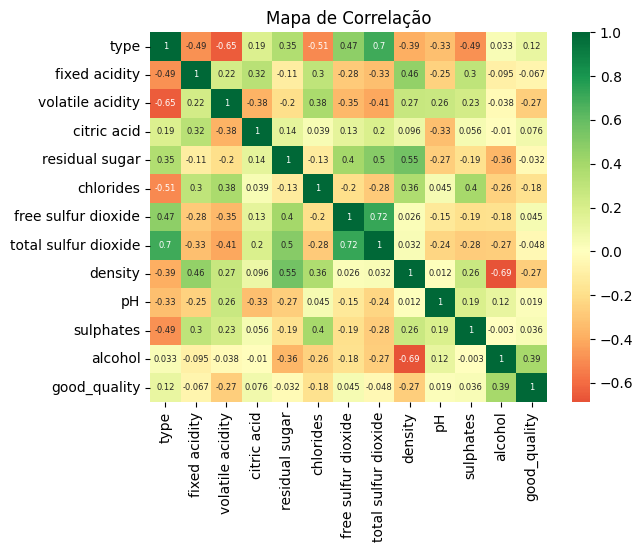

In [138]:
# Target binária: quality > 5 → bom (1), senão ruim (0)
df['good_quality'] = (df['quality'] > 5).astype(int)
df.drop('quality', axis=1, inplace=True)

# Encoding da coluna 'type' se necessário
if df['type'].dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])
    print("Coluna 'type' codificada.")

# Análise de distribuição
print("\nDistribuição das classes (good_quality):")
print(df['good_quality'].value_counts())
sns.countplot(x='good_quality', hue='good_quality', data=df, palette={0: 'red', 1: 'green'}, legend=False)
plt.title("Distribuição dos rótulos (0 = ruim, 1 = bom)")
plt.show()
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 6}, cmap='RdYlGn', center=0)
plt.title("Mapa de Correlação")
plt.show()
X = df.drop('good_quality', axis=1)
y = df['good_quality']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Seção 0: Decision Tree sem Balanceamento

In [140]:
# Caminho de poda para valores de ccp_alpha
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = np.unique(np.round(path.ccp_alphas, 4))[::max(1, len(path.ccp_alphas)//10)]

# Grade de hiperparâmetros
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 2, 5],
    'min_impurity_decrease': [0.0, 0.001, 0.01],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
    'ccp_alpha': ccp_alphas
}

# Otimização com GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Melhor modelo
clf_tree = grid_search.best_estimator_
print("Melhores parâmetros encontrados:", grid_search.best_params_)

Melhores parâmetros encontrados: {'ccp_alpha': np.float64(0.0), 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0}


In [141]:
# Treinamento do modelo
clf_tree = treinar_decision_tree(X_train, y_train)

In [142]:
# Avaliação de métricas básicas
tabela_metricas_tree = gerar_tabela_metricas(clf_tree, X_train, y_train, X_test, y_test)
print("\n===== Tabela de Métricas (Decision Tree Puro) =====")
print(tabela_metricas_tree)
acc_train_tree_puro = accuracy_score(y_train, clf_tree.predict(X_train))
acc_test_tree_puro = accuracy_score(y_test, clf_tree.predict(X_test))
print(f"\nAcurácia Treino (Decision Tree): {acc_train_tree_puro:.4f}")
print(f"Acurácia Teste  (Decision Tree): {acc_test_tree_puro:.4f}")


===== Tabela de Métricas (Decision Tree Puro) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão     0.708779     0.82473  0.766755        0.782185
       Recall        0.69392    0.834751  0.764336        0.783077
       F1-Score     0.701271     0.82971  0.765491        0.782583
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão          1.0         1.0       1.0             1.0
       Recall            1.0         1.0       1.0             1.0
       F1-Score          1.0         1.0       1.0             1.0
       Suporte        1907.0      3290.0       NaN             NaN

Acurácia Treino (Decision Tree): 1.0000
Acurácia Teste  (Decision Tree): 0.7831


In [143]:
# Avaliação por Cross-Validation
cv_mean_tree, diff_tree = avaliar_cross_validation(clf_tree, X_train, y_train, acc_test_tree_puro, "Decision Tree")


CV Accuracy: 0.7620 ± 0.0160
Modelo generaliza bem com base em CV vs Teste.


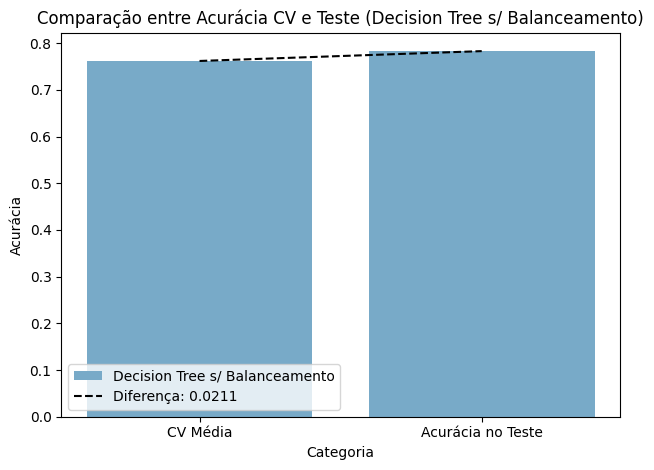

In [144]:
# Gráfico comparativo entre CV e Teste
plotar_comparacao_cv_teste(cv_mean_tree, acc_test_tree_puro, diff_tree, "Decision Tree s/ Balanceamento")

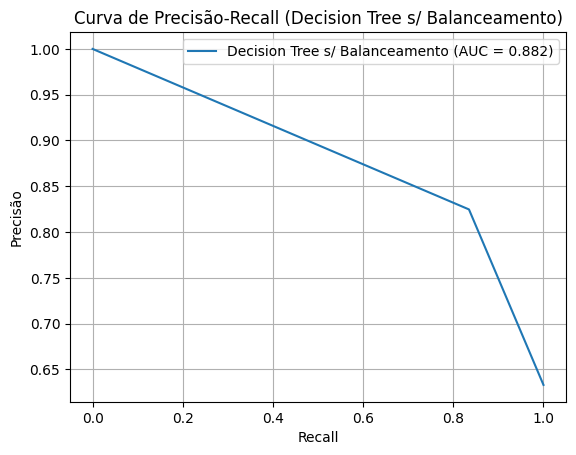

In [145]:
# Curva de Precisão-Recall
plotar_curva_precision_recall(clf_tree, X_test, y_test, "Decision Tree s/ Balanceamento")

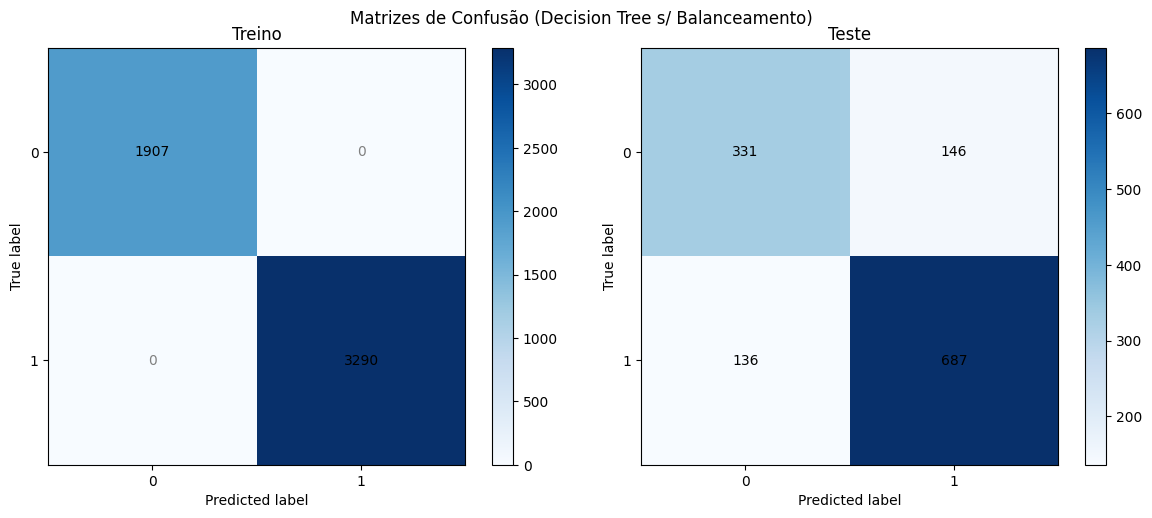

In [146]:
# Matrizes de Confusão
plotar_matrizes_confusao(clf_tree, X_train, y_train, X_test, y_test, "Decision Tree s/ Balanceamento")

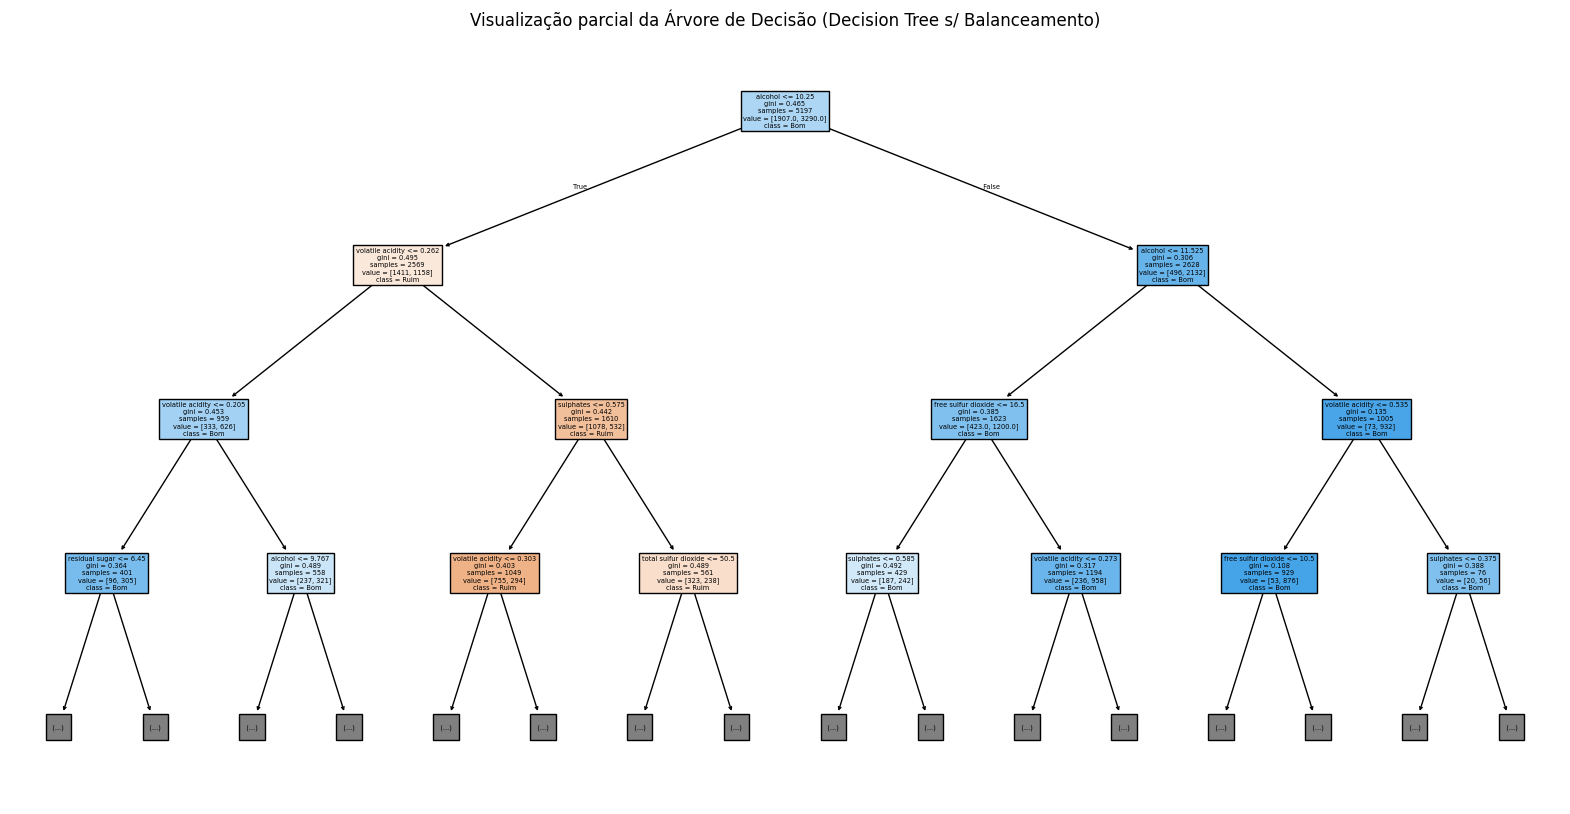

In [147]:
# Visualização da Árvore
visualizar_arvore(clf_tree, X_train, "Decision Tree s/ Balanceamento")

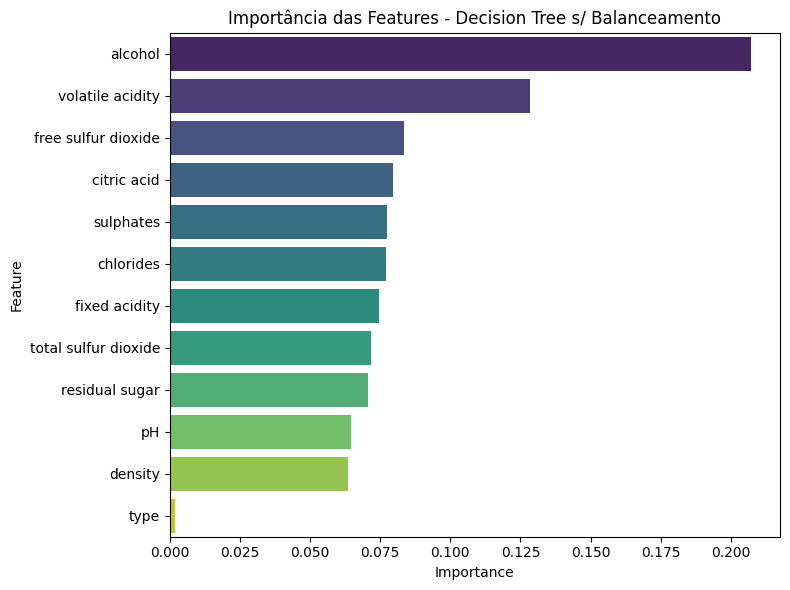

                 Feature  Importance
11               alcohol    0.207119
2       volatile acidity    0.128514
6    free sulfur dioxide    0.083555
3            citric acid    0.079528
10             sulphates    0.077408
5              chlorides    0.077003
1          fixed acidity    0.074448
7   total sulfur dioxide    0.071719
4         residual sugar    0.070671
9                     pH    0.064544
8                density    0.063709
0                   type    0.001783


In [148]:
# Importância das features
plotar_importancia_features(clf_tree, X_train, "Decision Tree s/ Balanceamento")

Seção 1: Decision Tree com class_weight

In [ ]:
# Grid de hiperparâmetros
param_grid_cw = param_grid.copy()
param_grid_cw['class_weight'] = ['balanced']
# GridSearch com class_weight
grid_search_cw = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_cw,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_cw.fit(X_train, y_train)
# Melhor modelo com class_weight
clf_tree_cw = grid_search_cw.best_estimator_
print("Melhores parâmetros com class_weight:", grid_search_cw.best_params_)

Melhores parâmetros com class_weight: {'ccp_alpha': np.float64(0.0), 'class_weight': 'balanced', 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0}


In [151]:
# Avaliação métricas básicas
tabela_metricas_tree_cw = gerar_tabela_metricas(clf_tree_cw, X_train, y_train, X_test, y_test)
print("\n===== Tabela de Métricas (Decision Tree com class_weight) =====")
print(tabela_metricas_tree_cw)
acc_train_tree_cw = accuracy_score(y_train, clf_tree_cw.predict(X_train))
acc_test_tree_cw = accuracy_score(y_test, clf_tree_cw.predict(X_test))
print(f"\nAcurácia Treino (Decision Tree class_weight): {acc_train_tree_cw:.4f}")
print(f"Acurácia Teste  (Decision Tree class_weight): {acc_test_tree_cw:.4f}")


===== Tabela de Métricas (Decision Tree com class_weight) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão     0.702306    0.827461  0.764883        0.781538
       Recall       0.702306    0.827461  0.764883        0.781538
       F1-Score     0.702306    0.827461  0.764883        0.781538
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão          1.0         1.0       1.0             1.0
       Recall            1.0         1.0       1.0             1.0
       F1-Score          1.0         1.0       1.0             1.0
       Suporte        1907.0      3290.0       NaN             NaN

Acurácia Treino (Decision Tree class_weight): 1.0000
Acurácia Teste  (Decision Tree class_weight): 0.7815


In [158]:
# Debug
from sklearn.metrics import classification_report
print(classification_report(y_test, clf_tree_cw.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       477
           1       0.83      0.83      0.83       823

    accuracy                           0.78      1300
   macro avg       0.76      0.76      0.76      1300
weighted avg       0.78      0.78      0.78      1300



In [152]:
# Avaliação por Cross-Validation
cv_mean_tree_cw, diff_tree_cw = avaliar_cross_validation(clf_tree_cw, X_train, y_train, acc_test_tree_cw, "Decision Tree class_weight")


CV Accuracy: 0.7554 ± 0.0136
Modelo generaliza bem com base em CV vs Teste.


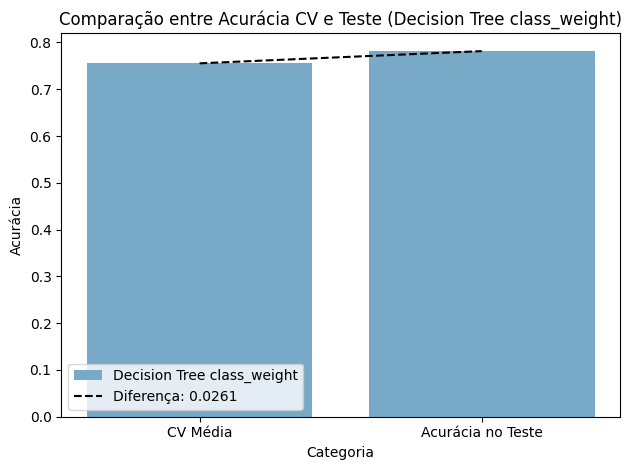

In [153]:
# Gráfico comparativo entre CV e Teste
plotar_comparacao_cv_teste(cv_mean_tree_cw, acc_test_tree_cw, diff_tree_cw, "Decision Tree class_weight")

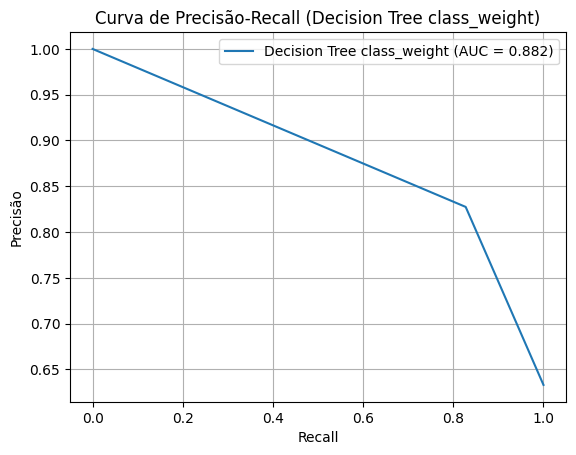

In [154]:
# Curva de Precisão-Recall
plotar_curva_precision_recall(clf_tree_cw, X_test, y_test, "Decision Tree class_weight")

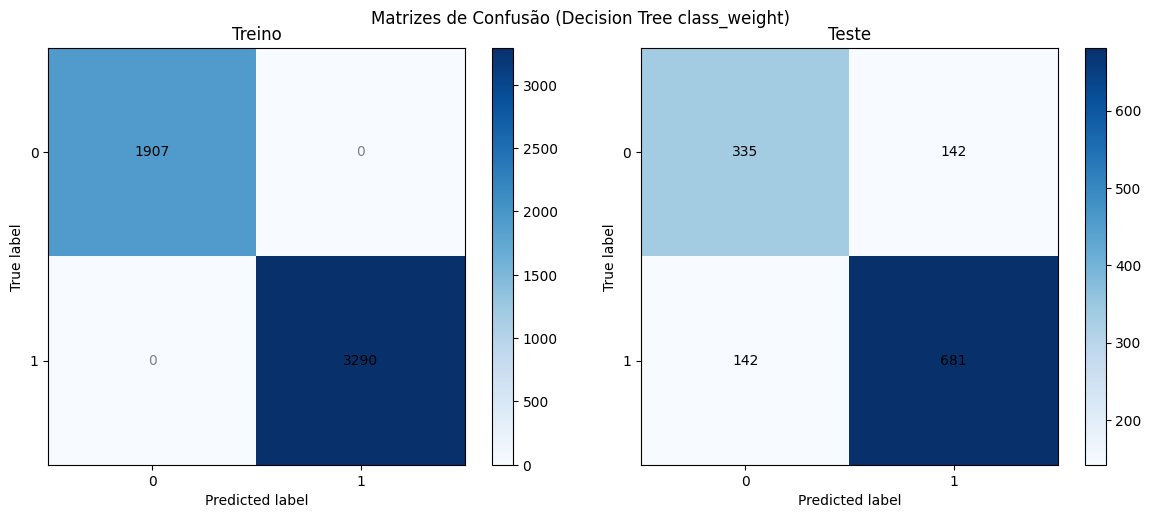

In [155]:
# Matrizes de Confusão
plotar_matrizes_confusao(clf_tree_cw, X_train, y_train, X_test, y_test, "Decision Tree class_weight")

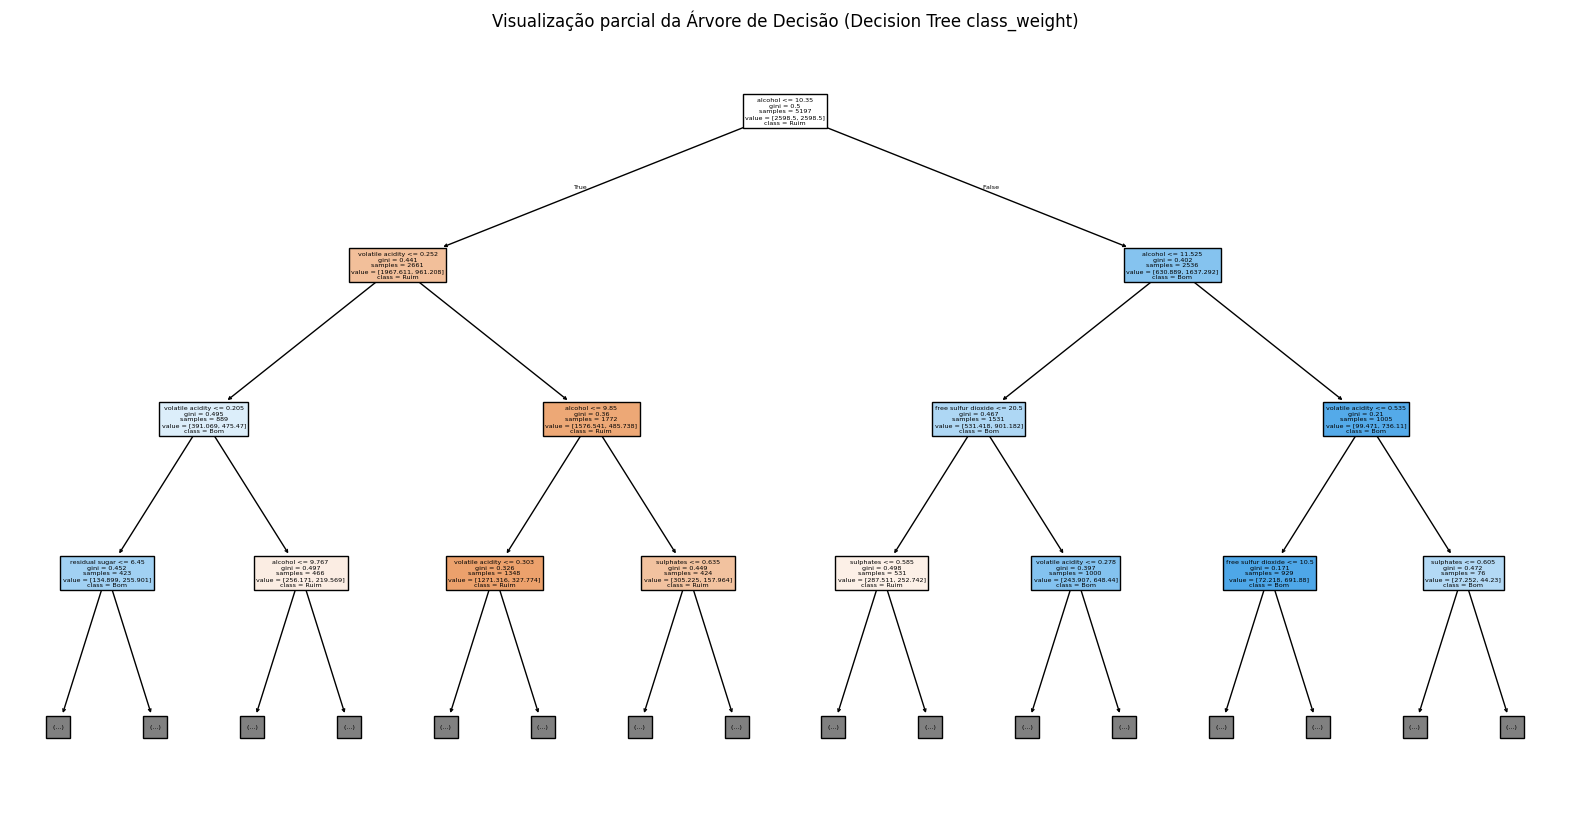

In [156]:
# Visualização da Árvore
visualizar_arvore(clf_tree_cw, X_train, "Decision Tree class_weight")

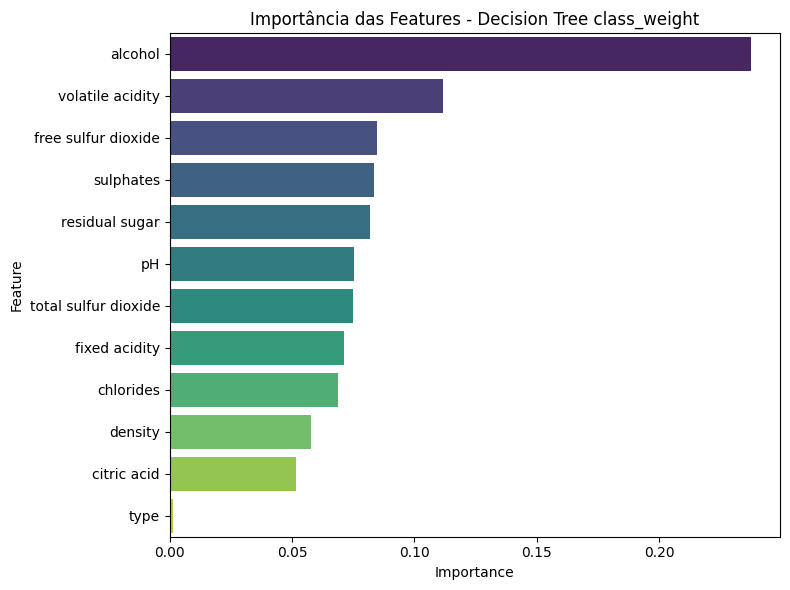

                 Feature  Importance
11               alcohol    0.237429
2       volatile acidity    0.111761
6    free sulfur dioxide    0.084877
10             sulphates    0.083466
4         residual sugar    0.081742
9                     pH    0.075289
7   total sulfur dioxide    0.074797
1          fixed acidity    0.071110
5              chlorides    0.068960
8                density    0.057631
3            citric acid    0.051579
0                   type    0.001360


In [157]:
# Importância das features
plotar_importancia_features(clf_tree_cw, X_train, "Decision Tree class_weight")

Seção 2: Decision Tree com Undersampling

In [159]:
from imblearn.under_sampling import RandomUnderSampler

# Aplicando Undersampling no conjunto de treino
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print("Distribuição após Undersampling:")
print(pd.Series(y_res).value_counts())

Distribuição após Undersampling:
good_quality
0    1907
1    1907
Name: count, dtype: int64


In [ ]:
# Grid de hiperparâmetros
param_grid_under = param_grid.copy()
# GridSearch com dados reduzidos (undersampling)
grid_search_under = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_under,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_under.fit(X_res, y_res)

clf_tree_under = grid_search_under.best_estimator_
print("Melhores parâmetros com Undersampling:", grid_search_under.best_params_)

Melhores parâmetros com Undersampling: {'ccp_alpha': np.float64(0.0), 'max_depth': 10, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0}


In [161]:
# Avaliação com conjunto de teste original (X_test, y_test)
tabela_metricas_tree_under = gerar_tabela_metricas(clf_tree_under, X_res, y_res, X_test, y_test)
print("\n===== Tabela de Métricas (Decision Tree com Undersampling) =====")
print(tabela_metricas_tree_under)
acc_train_tree_under = accuracy_score(y_res, clf_tree_under.predict(X_res))
acc_test_tree_under = accuracy_score(y_test, clf_tree_under.predict(X_test))
print(f"\nAcurácia Treino (Undersampling): {acc_train_tree_under:.4f}")
print(f"Acurácia Teste  (Undersampling): {acc_test_tree_under:.4f}")


===== Tabela de Métricas (Decision Tree com Undersampling) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão     0.592409    0.829971   0.71119        0.742804
       Recall       0.752621    0.699878   0.72625        0.719231
       F1-Score     0.662973    0.759394  0.711183        0.724015
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão     0.781933    0.830769  0.806351        0.806351
       Recall       0.844258    0.764552  0.804405        0.804405
       F1-Score     0.811901    0.796286  0.804094        0.804094
       Suporte        1907.0      1907.0       NaN             NaN

Acurácia Treino (Undersampling): 0.8044
Acurácia Teste  (Undersampling): 0.7192



CV Accuracy: 0.7305 ± 0.0153
Modelo generaliza bem com base em CV vs Teste.


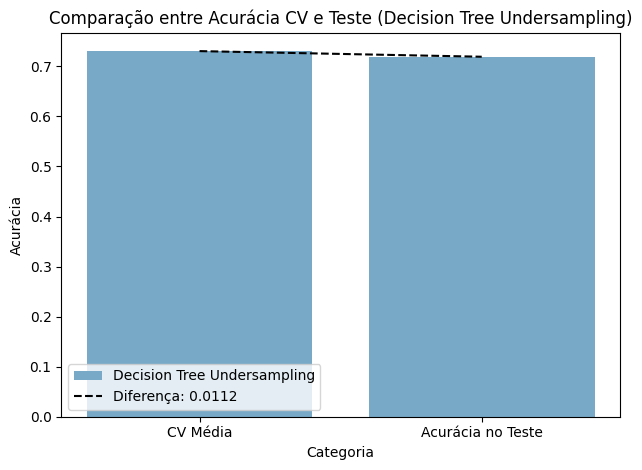

In [162]:
# Avaliação por Cross-Validation no conjunto reduzido
cv_mean_tree_under, diff_tree_under = avaliar_cross_validation(clf_tree_under, X_res, y_res, acc_test_tree_under, "Decision Tree Undersampling")

# Gráfico comparativo entre CV e Teste
plotar_comparacao_cv_teste(cv_mean_tree_under, acc_test_tree_under, diff_tree_under, "Decision Tree Undersampling")

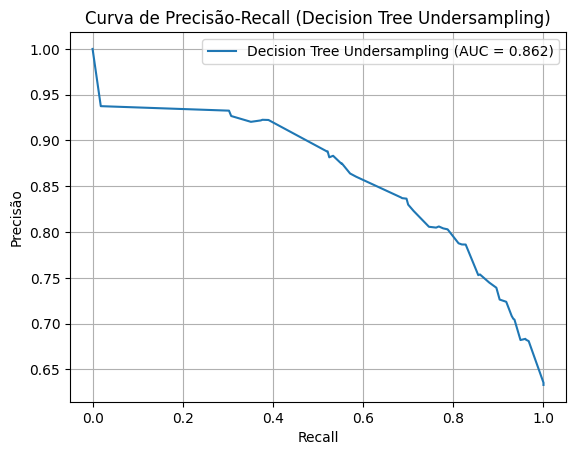

In [163]:
# Curva de Precisão-Recall no teste
plotar_curva_precision_recall(clf_tree_under, X_test, y_test, "Decision Tree Undersampling")

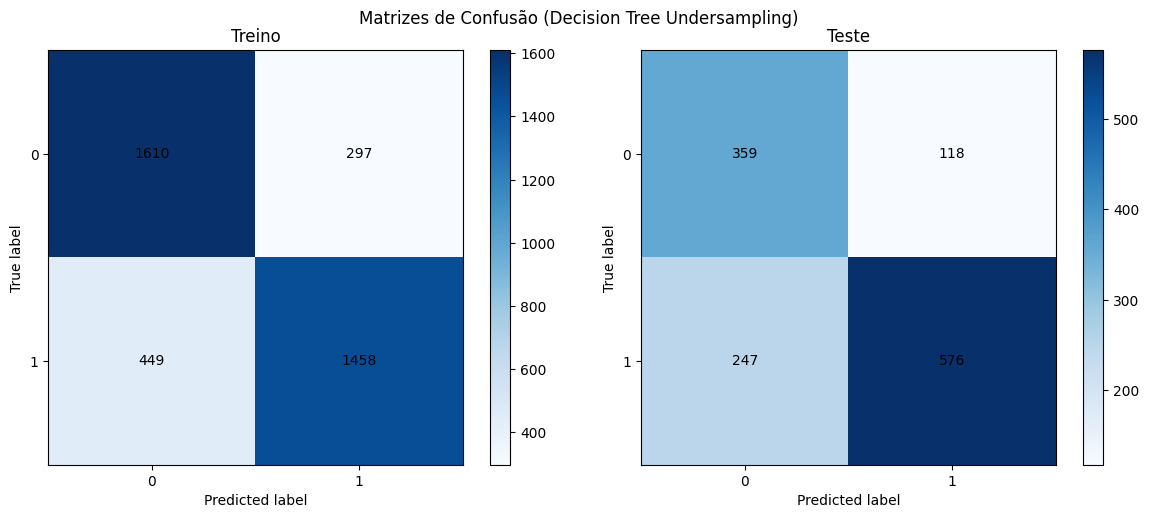

In [164]:
# Matrizes de Confusão
plotar_matrizes_confusao(clf_tree_under, X_res, y_res, X_test, y_test, "Decision Tree Undersampling")

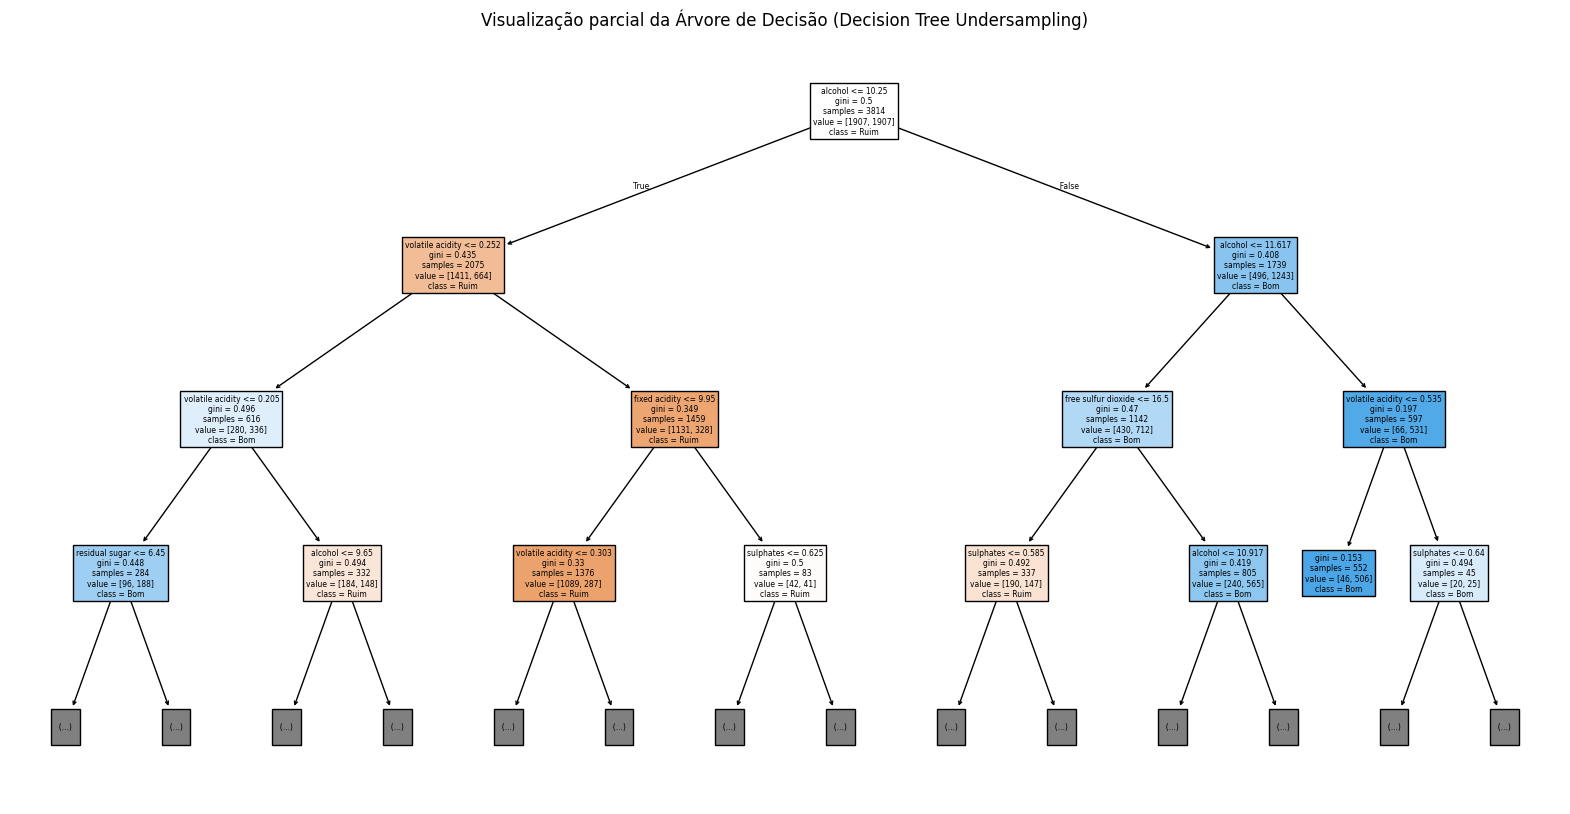

In [165]:
# Visualização da Árvore
visualizar_arvore(clf_tree_under, X_res, "Decision Tree Undersampling")

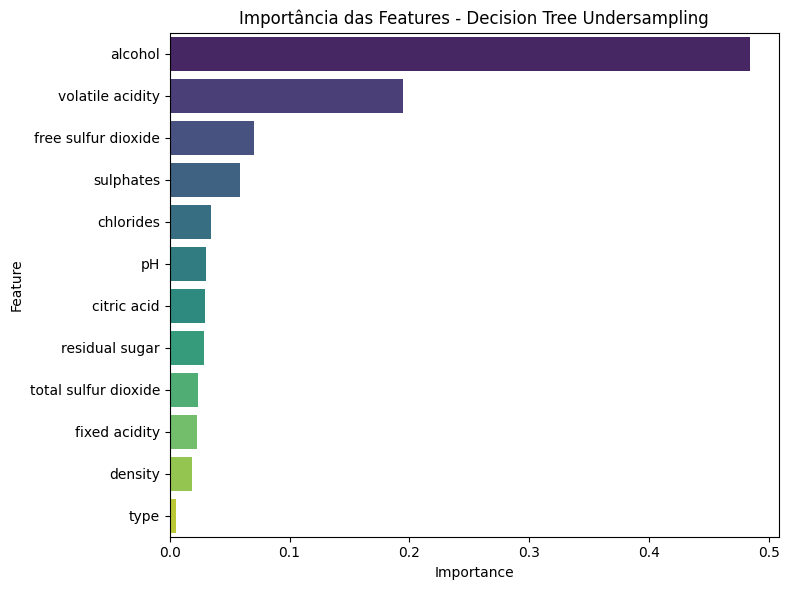

                 Feature  Importance
11               alcohol    0.483671
2       volatile acidity    0.194691
6    free sulfur dioxide    0.070611
10             sulphates    0.058824
5              chlorides    0.034135
9                     pH    0.029981
3            citric acid    0.029279
4         residual sugar    0.028782
7   total sulfur dioxide    0.023727
1          fixed acidity    0.022415
8                density    0.018560
0                   type    0.005325


In [166]:
# Importância das features
plotar_importancia_features(clf_tree_under, X_res, "Decision Tree Undersampling")